In [4]:
# We need pillow version of 5.3.0
# We will uninstall the older version first
!pip uninstall -y Pillow
# Install the new one
!pip install Pillow==5.3.0
!pip install image
!pip install http://download.pytorch.org/whl/cu80/torch-0.4.0-cp36-cp36m-linux_x86_64.whl
!pip install torchvision
import PIL

Uninstalling Pillow-7.0.0:
  Successfully uninstalled Pillow-7.0.0
     |████████████████████████████████| 2.0MB 9.5MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


     |████████████████████████████████| 484.0MB 1.2MB/s 
ERROR: torchvision 0.5.0 has requirement torch==1.4.0, but you'll have torch 0.4.0 which is incompatible.
ERROR: fastai 1.0.60 has requirement torch>=1.0.0, but you'll have torch 0.4.0 which is incompatible.
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
     |████████████████████████████████| 753.4MB 21kB/s 
  Found existing installation: torch 0.4.0
    Uninstalling torch-0.4.0:
      Successfully uninstalled torch-0.4.0


In [1]:
# We will verify that GPU is enabled for this notebook
# Following should print: CUDA is available!  Training on GPU ...
# if it prints otherwise, then you need to enable GPU: 
# From Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
from collections import OrderedDict
from torch.autograd import Variable
from PIL import Image
from torch.optim import lr_scheduler
import copy
import json
import os
from os.path import exists
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

CUDA is available!  Training on GPU ...
cuda:0


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#Organizing the dataset
data_dir = '/content/gdrive/My Drive/Plant Disease Detection/MarkoArsenovic/PlantVillage'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/val'
nThreads = 4
batch_size = 32
use_gpu = torch.cuda.is_available()

In [4]:
import os
os.chdir('/content/gdrive/My Drive/Plant Disease Detection/MarkoArsenovic/PlantVillage')#change dir
!ls

categories.json  plants9615_checkpoint.pth  train  val


# Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). 


In [5]:
import json

with open('categories.json', 'r') as f:
    cat_to_name = json.load(f)

cat_to_name

{'Pepper,_bell___Bacterial_spot': 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy': 'Pepper,_bell___healthy',
 'Potato___Early_blight': 'Potato___Early_blight',
 'Potato___Late_blight': 'Potato___Late_blight',
 'Potato___healthy': 'Potato___healthy',
 'Tomato___Bacterial_spot': 'Tomato___Bacterial_spot',
 'Tomato___Early_blight': 'Tomato___Early_blight',
 'Tomato___Late_blight': 'Tomato___Late_blight',
 'Tomato___Leaf_Mold': 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot': 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite': 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot': 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus': 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy': 'Tomato___healthy'}

In [0]:
TRAIN=False
TEST=True

In [0]:
if TRAIN:
    # Define your transforms for the training and validation sets
    # Data augmentation and normalization for training
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomRotation(30),
            transforms.RandomResizedCrop(224),
            #transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    # Load the datasets with ImageFolder


    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['train', 'val']}

    print(image_datasets)

    # Using the image datasets and the trainforms, define the dataloaders
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                                shuffle=True, num_workers=4)
                  for x in ['train', 'val']}

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

    class_names = image_datasets['train'].classes

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features. Resnet-152 pretrained model is used for this image classifier.

In [0]:
if TRAIN: 
    # Build and train your network

    # 1. Load resnet-152 pre-trained network
    model = models.resnet152(pretrained=True)
    # Freeze parameters so we don't backprop through them

    for param in model.parameters():
        param.requires_grad = False

    #Let's check the model architecture:
    print(model)

    # 2. Define a new, untrained feed-forward network as a classifier, using ReLU activations
    # Our input_size matches the in_features of pretrained model

    from collections import OrderedDict
    # Creating the classifier ordered dictionary first
    classifier = nn.Sequential(OrderedDict([
                              ('fc1', nn.Linear(2048, 512)),
                              ('relu', nn.ReLU()),
                              ('fc2', nn.Linear(512, 15)),
                              ('output', nn.LogSoftmax(dim=1))
                              ]))
    # Replacing the pretrained model classifier with our classifier
    model.fc = classifier

In [0]:
#Function to train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            

            if phase=='train':
                train_loss_list.append(epoch_loss)
                train_acc_list.append(epoch_acc)
            else:
                val_loss_list.append(epoch_loss)
                val_acc_list.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
if TRAIN: 
    # Train a model with a pre-trained network
    num_epochs = 25
    if use_gpu:
        print ("Using GPU: "+ str(use_gpu))
        model = model.cuda()

    # Create lists for plotting accuraries and cost loss
    train_acc_list,val_acc_list=[],[]
    train_loss_list,val_loss_list=[],[]
    # NLLLoss because our output is LogSoftmax
    criterion = nn.NLLLoss()
    # Adam optimizer with a learning rate
    optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
    # Decay LR by a factor of 0.1 every 5 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)

    #Plot graphs using MatplotLiB 
    #Train and validation accuracy
    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, train_acc_list, 'b', label='Training accurarcy')
    plt.plot(epochs, val_acc_list, 'r', label='Validation accurarcy')
    plt.title('Training and Validation accurarcy')
    plt.legend()

    plt.figure()
    #Train and validation loss
    plt.plot(epochs, train_loss_list, 'b', label='Training loss')
    plt.plot(epochs, val_loss_list, 'r', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.show()

In [0]:
# Do validation on the test set
def test(model, dataloaders, device):
  model.eval()
  accuracy = 0
  
  model.to(device)
    
  for images, labels in dataloaders['val']:
    images = Variable(images)
    labels = Variable(labels)
    images, labels = images.to(device), labels.to(device)
      
    output = model.forward(images)
    ps = torch.exp(output)
    equality = (labels.data == ps.max(1)[1])
    accuracy += equality.type_as(torch.FloatTensor()).mean()
      
    print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['val'])))

if TRAIN:
    test(model, dataloaders, device)

# Save the checkpoint

Now that the network is trained,  we will save the model so we can load it later for making predictions. We will save the mapping of classes to indices which we get from one of the image datasets: `image_datasets['train'].class_to_idx`. We will attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

In [0]:
if TRAIN: 
    # Save the checkpoint 
    model.class_to_idx = dataloaders['train'].dataset.class_to_idx
    model.epochs = num_epochs
    checkpoint = {'input_size': [3, 224, 224],
                    'batch_size': dataloaders['train'].batch_size,
                      'output_size': 15,
                      'state_dict': model.state_dict(),
                      'data_transforms': data_transforms,
                      'optimizer_dict':optimizer.state_dict(),
                      'class_to_idx': model.class_to_idx,
                      'epoch': model.epochs}
    torch.save(checkpoint, 'plants9615_checkpoint.pth')

# Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. 

In [0]:
# Write a function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = models.resnet152()
    
    # Our input_size matches the in_features of pretrained model
    input_size = 2048
    output_size = 15
    
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 512)),
                          ('relu', nn.ReLU()),
                          #('dropout1', nn.Dropout(p=0.2)),
                          ('fc2', nn.Linear(512, 15)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

# Replacing the pretrained model classifier with our classifier
    model.fc = classifier
    
    
    model.load_state_dict(checkpoint['state_dict'])
    
    return model, checkpoint['class_to_idx']

if TEST:
    # Get index to class mapping
    loaded_model, class_to_idx = load_checkpoint('plants9615_checkpoint.pth')
    idx_to_class = { v : k for k,v in class_to_idx.items()}

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model

    size = 256, 256
    image.thumbnail(size, Image.ANTIALIAS)
    image = image.crop((128 - 112, 128 - 112, 128 + 112, 128 + 112))
    npImage = np.array(image)
    npImage = npImage/255.
        
    imgA = npImage[:,:,0]
    imgB = npImage[:,:,1]
    imgC = npImage[:,:,2]
    
    imgA = (imgA - 0.485)/(0.229) 
    imgB = (imgB - 0.456)/(0.224)
    imgC = (imgC - 0.406)/(0.225)
        
    npImage[:,:,0] = imgA
    npImage[:,:,1] = imgB
    npImage[:,:,2] = imgC
    
    npImage = np.transpose(npImage, (2,0,1))
    
    return npImage

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    print(image)
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

# Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Implement the code to predict the class from an image file
    
    image = torch.FloatTensor([process_image(Image.open(image_path))])
    model.eval()
    output = model.forward(Variable(image))
    pobabilities = torch.exp(output).data.numpy()[0]
    

    top_idx = np.argsort(pobabilities)[-topk:][::-1] 
    top_class = [idx_to_class[x] for x in top_idx]
    top_probability = pobabilities[top_idx]

    return top_probability, top_class

In [25]:
!ls

categories.json  plants9615_checkpoint.pth  train  val


In [26]:
if TEST: 
    print(predict('val/Potato___healthy/3f369e63-81eb-4194-a145-df9ed91abc5d___RS_HL 1745.JPG', loaded_model))

(array([9.93320465e-01, 5.11790253e-03, 1.13075669e-03, 1.02540456e-04,
       6.92413523e-05], dtype=float32), ['Potato___healthy', 'Pepper,_bell___healthy', 'Potato___Late_blight', 'Pepper,_bell___Bacterial_spot', 'Potato___Early_blight'])


In [0]:
# Display an image along with the top 5 classes
def view_classify(img, probabilities, classes, mapper):
    ''' Function for viewing an image and it's predicted classes.
    '''
    img_filename = img.split('/')[-2]
    img = Image.open(img)

    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
    flower_name = mapper[img_filename]
    
    ax1.set_title(flower_name)
    ax1.imshow(img)
    ax1.axis('off')
    
    y_pos = np.arange(len(probabilities))
    ax2.barh(y_pos, probabilities)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([mapper[x] for x in classes])
    ax2.invert_yaxis()

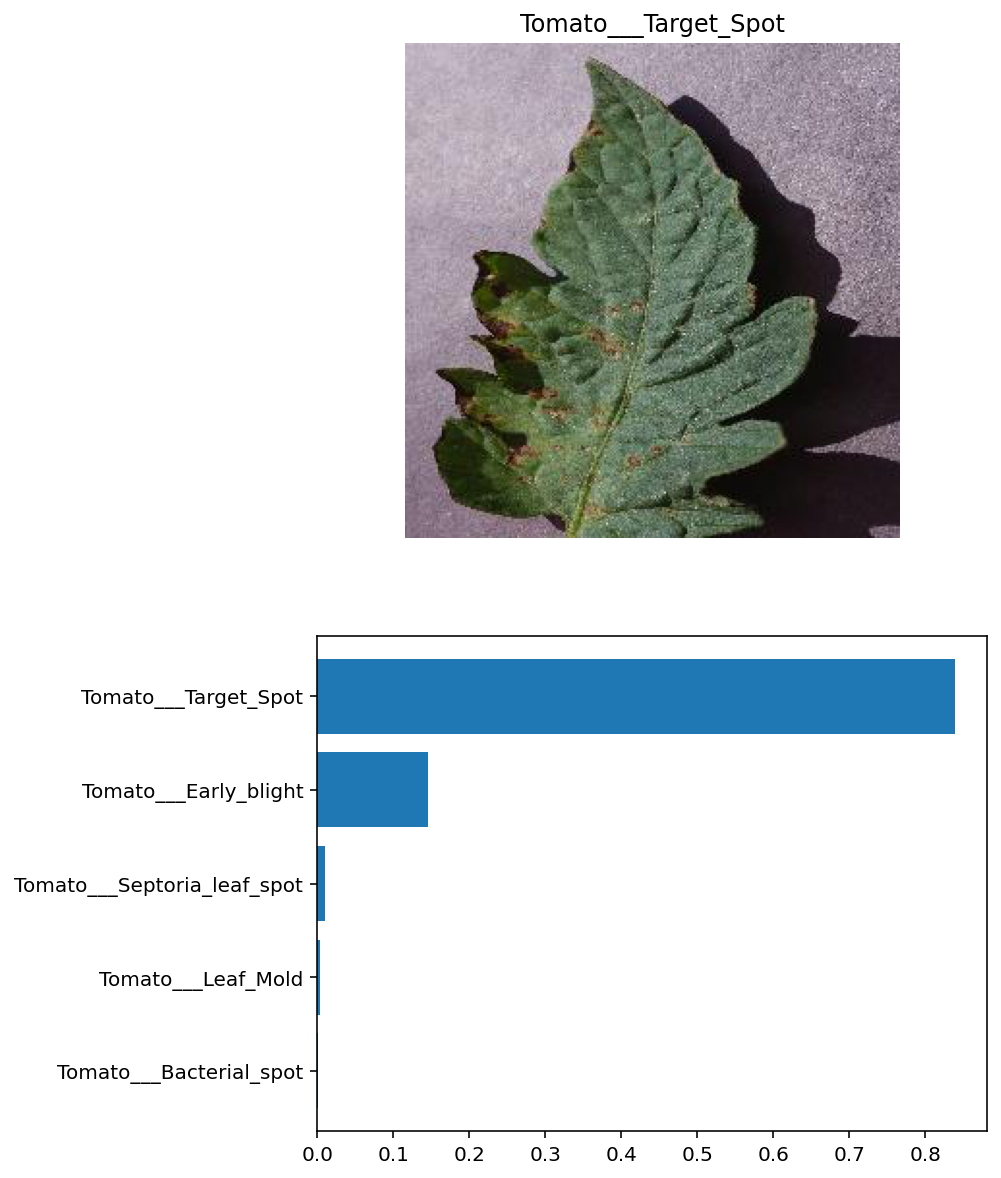

In [28]:
if TEST: 
    img = 'val/Tomato___Target_Spot/e2c3ecfd-9637-4158-9400-315f5949b7f4___Com.G_TgS_FL 7962.JPG'
    p, c = predict(img, loaded_model)
    view_classify(img, p, c, cat_to_name)